# Lecture 7 - Special Topics in Image Processing

In this notebook, we will discuss special topics in processing our images Specifically, we will discuss:
1. Homography Matrix
1. Texture Metrics

Authored by:
Benjur Emmanuel L. Borja

---

We have discussed the different fundamentals in reading, cleaning, and detecting points of interests in our image. In this notebook, we will be applying special methods in transforming and generating features from our image.

## 1. Homography Matrix
**Homography** is defined as the mapping between two planar projections of an image. In the simplest of terms, it is using reference points in the original image to reorient it to fit into a new shape.  It is represented by a 3x3 transformation matrix in a homogenous coordinates space. These transformations can be a combination of rotation, translation, scaling, or skew operations. 

To illustrate:
<img src="transform.png" alt="transform" width="400"/>

The documentation for the transform in skimage summarizes these transforms neatly:

https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html

However, these examples explicitly defines the transform. What if we are given the input and output image? Depending on the transform, we would need several points to compute for our homography matrix. First we try it with a simple image of a chess board.  We transform it from an orientation in 3D-space into a more 2D-representation (top view) using the corners of the board.

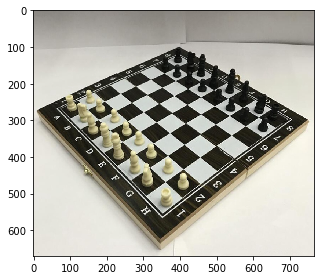

In [3]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np


chess = imread('chess.PNG')
imshow(chess)

Now we want to have a top down view of this chess board. We would need to compute for the homography matrix. We have pre-determined the corners of the chess board using the following:

In [4]:
src = np.array([391, 100,
                14, 271,
                347, 624,
                747, 298,
]).reshape((4, 2))

In [16]:
dst = np.array([100, 100,
                100, 650,
                650, 650,
                650, 100,
]).reshape((4, 2))

We know that the transformation is projective, so we use that as our parameter:

In [6]:
from skimage import transform
tform = transform.estimate_transform('projective', src, dst)

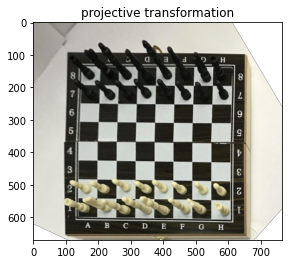

In [7]:
tf_img = transform.warp(chess, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')

#### Exercise:
Now we try something a little more complicated:  In the next set of transformations, we take still shots of a basketball game and reorient it into an overhead view of the court.  For this we use the corners of the free-throw box as reference point for the transformation.

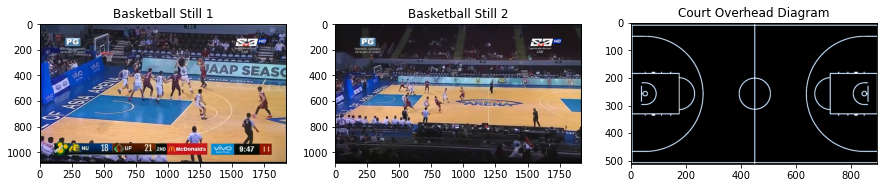

In [12]:
bball1 = imread('still1.png')
bball2 = imread('still2.png')
court = imread('court.png')

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(bball1)
ax[0].set_title('Basketball Still 1')
ax[1].imshow(bball2)
ax[1].set_title('Basketball Still 2')
ax[2].imshow(court)
ax[2].set_title('Court Overhead Diagram');

In [56]:
src1 = np.array([694, 402,
                190, 721,
                1015, 788,
                1190, 599,
]).reshape((4, 2))

a = 1920/894
b = 1080/512

dst1 = dst = np.array([5, 8,
                5, 330,
                173, 330,
                173, 184,
]).reshape((4, 2))

dst1[:,0] = dst1[:,0]*a
dst1[:,1] = dst1[:,1]*b

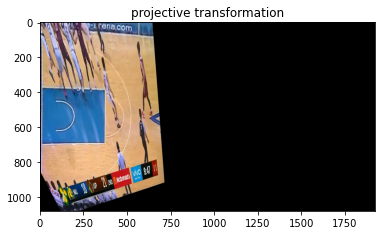

In [57]:
tform = transform.estimate_transform('projective', src1, dst1)
tf_img = transform.warp(bball1, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')

In [86]:
src2 = np.array([335, 545,
                200, 630,
                680, 550,
                608, 640,
]).reshape((4, 2))

dst2 = np.array([8, 182,
                8, 329,
                175, 182,
                175, 329,
]).reshape((4, 2))

dst2[:,0] = dst2[:,0]*a
dst2[:,1] = dst2[:,1]*b

# print(src2, dst2)

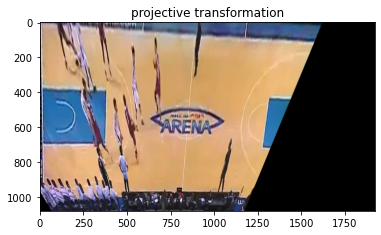

In [87]:
tform = transform.estimate_transform('projective', src2, dst2)
tf_img = transform.warp(bball2, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')

## 2. Texture Metrics

Given that some of the images that we will consider have inconsistent color information(white balancing, color variations, etc), we need to have another measure that can characterize our images. We can instead look at the spatial arrangement of our intentisty values, called **Texture**. There are various type of texture metrics that we can look, each with its own uses. This is simillar to the spatial filters that we have previously used.

To compute for the texture of an image, we use the following steps:
1. Define a moving window across our image.
1. Compute for the occurence histogram of the graylevels in the window
1. Compute for the Probability array given the window.
1. Compute for the corresponding Texture Metric given the Probability array.

This method assigns a specific texture metric at the center of our moving window. We can then iterate our moving window accross the entirety of our image to compute for the texture metric.

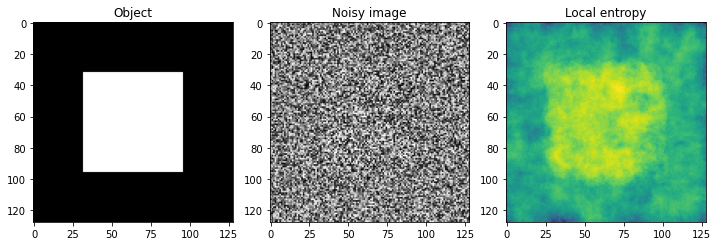

In [92]:
# https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

noise_mask = np.full((128, 128), 28, dtype=np.uint8)
noise_mask[32:-32, 32:-32] = 30

noise = (noise_mask * np.random.random(noise_mask.shape) - 0.5 *
         noise_mask).astype(np.uint8)
img = noise + 128

entr_img = entropy(img, disk(10))

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

img0 = ax0.imshow(noise_mask, cmap='gray')
ax0.set_title("Object")
ax1.imshow(img, cmap='gray')
ax1.set_title("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_title("Local entropy")

fig.tight_layout()

#### Exercise:
Now we apply to concept in an attempt to segment the damaged areas from the still-standing buildings in a satellite photo.  In the hopes of having a more texturally varied photo, first we transform our image into the HSV colour space.  For the actual entropy process then, we use the saturation values of the image.  The first step is to find an appropriate entropy radius value to pinpoint areas of different texture.  Then we apply different thresholds to the entropy image to find a suitable level of separation.

(360, 359)


<ipython-input-152-f6bbe059ed80>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img_raw)


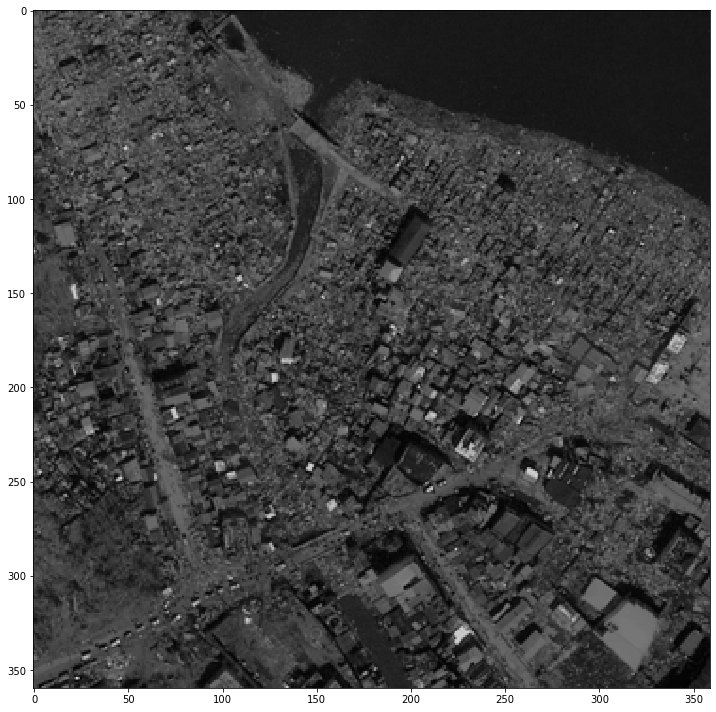

In [152]:
from skimage.color import rgb2gray

img_raw = imread('sat.png')
img_gray = rgb2gray(img_raw)

print(img_gray.shape)
plt.figure(figsize=(15,10))

imshow(img_gray)

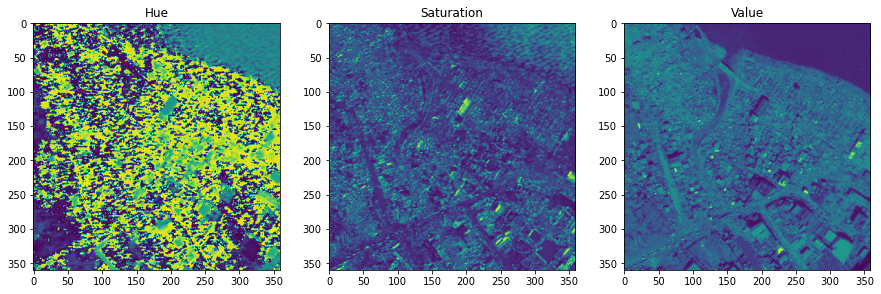

In [163]:
from skimage.color import rgb2hsv

img_hsv = rgb2hsv(img_raw[:,:,:3])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(img_hsv[:,:,0])
ax[0].set_title('Hue')
ax[1].imshow(img_hsv[:,:,1])
ax[1].set_title('Saturation')
ax[2].imshow(img_hsv[:,:,2])
ax[2].set_title('Value');

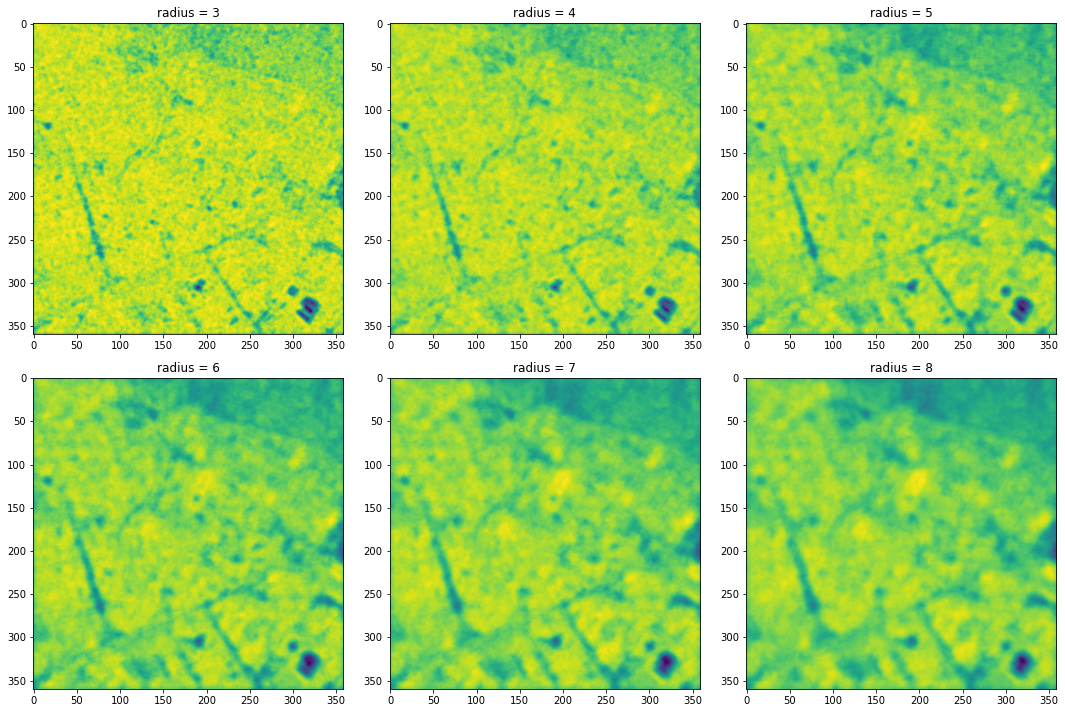

In [164]:
fig = plt.figure(figsize=(15,10))

for i in range(1,7):
    entropy_image = entropy(img_hsv[:,:,1], disk(i+2))
    plt.subplot(2,3,i), plt.imshow(entropy_image)
    plt.title(f'radius = {i+2}')

plt.tight_layout();

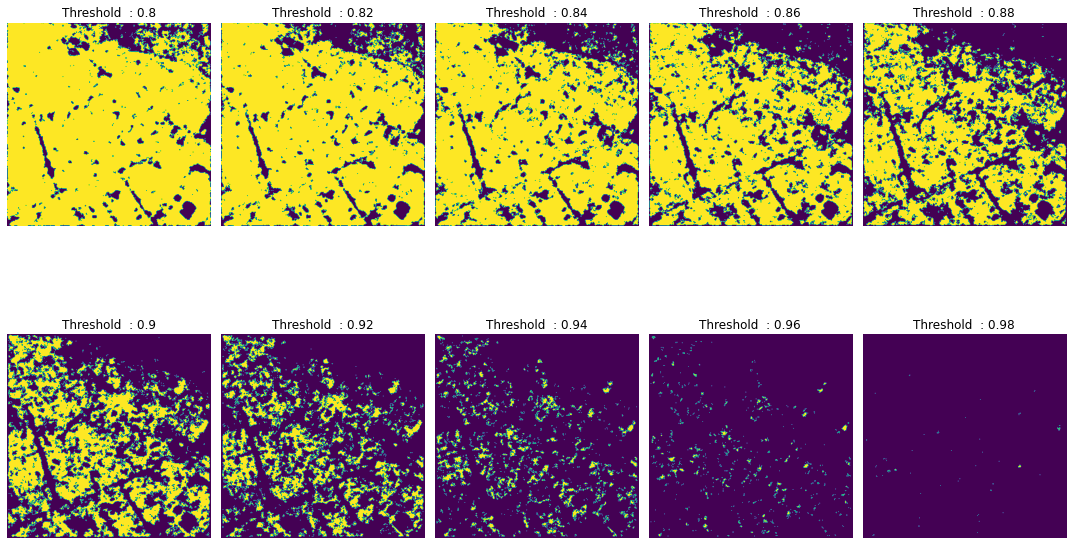

In [167]:
img_gray = img_hsv[:,:,1]
entropy_image = entropy(img_gray, disk(4))
scaled_entropy = entropy_image / entropy_image.max()

thresholds =  np.arange(0.8,1.0,0.02)

fig = plt.figure(figsize=(15, 10))
for i, n in enumerate(thresholds):
    threshold = scaled_entropy > n
    plt.subplot(2, 5, i+1), plt.imshow(threshold)
    plt.title(f'Threshold  : {round(n,2)}')
    plt.axis('off')
    
plt.tight_layout();

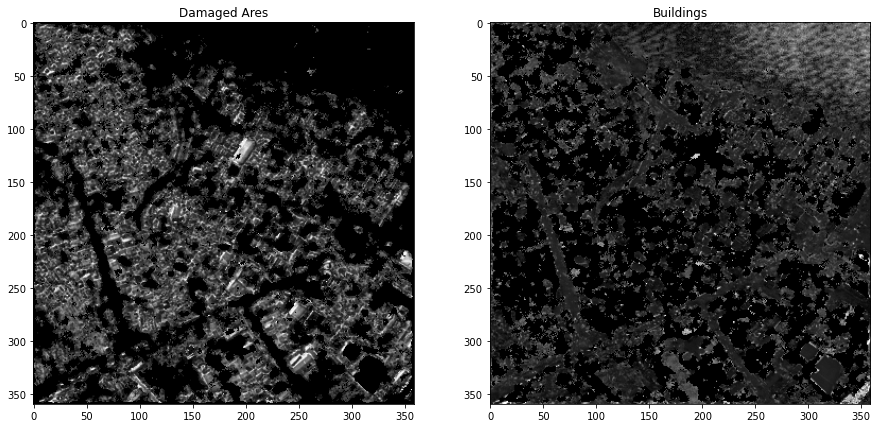

In [173]:
fig, ax = plt.subplots(1,2, figsize=(15,10))

mask_dmg = scaled_entropy > 0.88
ax[0].imshow(img_gray * mask_dmg, cmap = 'gray')
ax[0].set_title('Damaged Ares')

mask_bldg = scaled_entropy < 0.90
ax[1].imshow(img_gray * mask_bldg, cmap = 'gray')
ax[1].set_title('Buildings');